# Importing Necessary Libraries

In [1]:
# Dataframes
import numpy as np
import pandas as pd
from copy import deepcopy

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,8)
plt.style.use('ggplot')

# Scikit Learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans


from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D

C:\Users\prash\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initializing Parameters

In [2]:
# Path of the folder
path = 'C:/Users/prash/Downloads/ML ALGORITHMS/'

lr = 0.01
beta1 = 0.95
beta2 = 0.99

num_epochs = 2

batch_size = 20

train_set_length = 1000
test_set_length = 200


# Initializing Parameters

def Initialize_Filter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def Initialize_Weight(size):
    return np.random.standard_normal(size=size) * 0.01

f1 = (8,1,5,5)
f2 = (8,8,5,5)
w3 = (128,800)
w4 = (10,128)

f1 = Initialize_Filter(f1)
f2 = Initialize_Filter(f2)
w3 = Initialize_Weight(w3)
w4 = Initialize_Weight(w4)

b1 = np.zeros((f1.shape[0],1))
b2 = np.zeros((f2.shape[0],1))
b3 = np.zeros((w3.shape[0],1))
b4 = np.zeros((w4.shape[0],1))

params = {}
params['f1'] = f1
params['f2'] = f2
params['w3'] = w3
params['w4'] = w4
params['b1'] = b1
params['b2'] = b2
params['b3'] = b3
params['b4'] = b4

# Importing and Cleaning Datasets

In [3]:
mnist_train = pd.read_csv(path + 'DATASETS/' + 'mnist_train.csv')
mnist_test = pd.read_csv(path + 'DATASETS/' + 'mnist_test.csv')

X_train = np.array(mnist_train.iloc[:train_set_length,1:])
X_train = X_train.reshape(X_train.shape[0],28,28)
Y_train = np.array(mnist_train.iloc[:train_set_length,0])

X_test = np.array(mnist_test.iloc[:test_set_length,1:])
X_test = X_test.reshape(X_test.shape[0],28,28)
Y_test = np.array(mnist_test.iloc[:test_set_length,0])

# One Hot Encode the Output Labels
enc = OneHotEncoder()
Y_train = enc.fit_transform(Y_train.reshape(-1,1)).toarray()
Y_test = enc.fit_transform(Y_test.reshape(-1,1)).toarray()

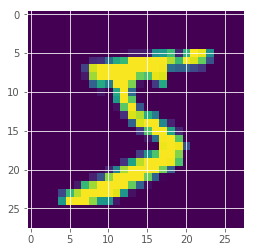

In [4]:
#plot the first image in the dataset
plt.imshow(X_train[0])

# Implementation From Scratch

### Forward Propagation

In [5]:
def Convolve(image, filt, bias, stride = 1):
    
    # Initialize the Filter and Image dimensions respectively
    (no_of_filters, filter_depth, filter_height, filter_width) = filt.shape
    (image_depth, image_height, image_width) = image.shape
    
    # Dimensions of filter must match dimensions of input image
    assert image_depth == filter_depth
    
    # Calculate the Output height
    out_height = int((image_height - filter_height) / stride) + 1 
    
    # Initialize the Output Dimensions
    out = np.zeros((no_of_filters,out_height,out_height))
    
    # Convolve Filter with the Image 
    for cur_filter in range(no_of_filters):
        # Initialize the counters for height of current and output image
        cur_y = out_y = 0
        while (cur_y + filter_height) <= image_height:
            # Initialize the counters for width of current and output image
            cur_x = out_x = 0
            while (cur_x + filter_width) <= image_width:
                # Convolve the filter with part of the image to get the Output Pixel Value
                out[cur_filter, out_y, out_x] = (np.sum(filt[cur_filter] * 
                                                        image[:,cur_y:(cur_y+filter_height), cur_x:(cur_x+filter_width)]) 
                                                 + bias[cur_filter])
                
                cur_x += stride
                out_x += 1
            cur_y += stride
            out_y += 1
        
    return out


def Max_Pool(image, filter_size = 2, stride = 2):
    
    # Initialize dimensions of Image
    (depth, prev_height, prev_width) = image.shape
    
    # Calculate Output Dimensions 
    height = int((prev_height - filter_size) / stride) + 1
    width = int((prev_width - filter_size) / stride) + 1
    
    # Initialize Output Dimensions
    downsampled = np.zeros((depth, height, width))
    
    # Slide maxpool window over each part of the image and assign the max value at each step to the output
    for i in range(depth):
        # Initialize the counters for height of current and output image
        cur_y = out_y = 0
        while (cur_y + filter_size) <= prev_height:
            # Initialize the counters for width of current and output image
            cur_x = out_x = 0
            while (cur_x + filter_size) <= prev_width:
                # MaxPooling
                downsampled[i, out_y, out_x] = np.max(image[i, cur_y:(cur_y+filter_size), cur_x:(cur_x+filter_size)])
                cur_x += stride
                out_x += 1
            cur_y += stride
            out_y += 1
    
    
    return downsampled

def Relu(X):
    X[X <= 0] = 0
    return X

def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)



def Forward_Propagation(input_data,params):
    
    #Initialize Parameters
    f1 =  params['f1']
    f2 = params['f2']
    w3 = params['w3']
    w4 = params['w4']
    b1 = params['b1']
    b2 = params['b2']
    b3 = params['b3']
    b4 = params['b4']
    
    
    # First Convolutional Layer
    conv1 = Convolve(input_data,f1,b1,stride = 1)
    # Applying Relu Activation Function
    conv1 = Relu(conv1)
    
    # Second Convolutional Layer
    conv2 = Convolve(conv1,f2,b2,stride = 1)
    # Applying Relu Activation Function
    conv2 = Relu(conv2)
    
    # Max Pooling 
    max_pooled_layer = Max_Pool(conv2,filter_size = 2, stride = 2)
    
    # Converting into Fully Connected Layer
    (pooled_layer_depth,pooled_layer_height,pooled_layer_width) = max_pooled_layer.shape
    fully_connected_layer = max_pooled_layer.reshape(((pooled_layer_depth*pooled_layer_height*pooled_layer_width),1))
    
    # First Dense Layer
    H1 = w3.dot(fully_connected_layer) + b3 
    # Applying Relu Activation Function
    H1 = Relu(H1)    
    
    # Second Dense Layer
    output = w4.dot(H1) + b4

    # Predict Class Probabilities with the Softmax Activation Function
    probs = softmax(output)
    
    # Instantiate Layers
    layers = {}
    layers['input_data'] = input_data
    layers['conv1'] = conv1
    layers['conv2'] = conv2
    layers['max_pooled_layer'] = max_pooled_layer
    layers['fully_connected_layer'] = fully_connected_layer
    layers['H1'] = H1
    layers['output'] = output
    layers['probs'] = probs
    
    return layers

### Back Propagation

In [6]:
# The gradients are passed through the indices of greatest value in the original maxpooling during the forward step
def Max_Pool_Backward(dpool, orig_layer, max_pool_size, stride):

    # Initialize dimensions of Original Max Pooling Layer
    (no_of_filters, orig_layer_height, orig_layer_width) = orig_layer.shape
    
    # Initialize dimensions of Output
    dout = np.zeros(orig_layer.shape)
    
    for cur_filter in range(no_of_filters):
        # Initialize the counters for height of current and output layer
        cur_y = out_y = 0
        while (cur_y + max_pool_size) <= orig_layer_height:
            # Initialize the counters for width of current and output layer
            cur_x = out_x = 0
            while (cur_x + max_pool_size) <= orig_layer_width:
                # Define the current window
                cur_window = orig_layer[cur_filter, cur_y:(cur_y+max_pool_size), cur_x:(cur_x+max_pool_size)]
                # obtain index of largest value in input for current window
                (a, b) = np.where(cur_window == cur_window.max())
                a = int(a[0])
                b = int(b[0])
                
                # Assign the values in the output layer
                dout[cur_filter, cur_y+a, cur_x+b] = dpool[cur_filter, out_y, out_x]
                
                cur_x += stride
                out_x += 1
            cur_y += stride
            out_y += 1
        
    return dout


def Convolution_Backward(dconv_prev, conv_layer, filt, stride):
    
    # Initialize Dimensions of Filter and Convolutional Layer
    (no_of_filters,filter_depth,filter_height,filter_width) = filt.shape
    (_, conv_layer_height, conv_layer_width) = conv_layer.shape
    
    # Initialize Dimensions of Derivatives
    dout = np.zeros(conv_layer.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((no_of_filters,1))
    
    for cur_filter in range(no_of_filters):
        # Initialize the counters for height of current and output layer
        cur_y = out_y = 0
        while (cur_y + filter_height) <= conv_layer_height:
            # Initialize the counters for width of current and output layer
            cur_x = out_x = 0
            while (cur_x + filter_width) <= conv_layer_width:
                
                # loss gradient of filter (used to update the filter)
                dfilt[cur_filter] += (dconv_prev[cur_filter, out_y, out_x] * 
                                      conv_layer[:, cur_y:(cur_y+filter_height), cur_x:(cur_x+filter_width)])
                
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, cur_y:(cur_y+filter_height), cur_x:(cur_x+filter_width)] += (dconv_prev[cur_filter, out_y, out_x] *
                                                                                     filt[cur_filter])
                
                cur_x += stride
                out_x += 1
            cur_y += stride
            out_y += 1
        
        # loss gradient of the bias
        dbias[cur_filter] = np.sum(dconv_prev[cur_filter])
    
    return dout, dfilt, dbias


def Categorical_Cross_Entropy(probs, label):
    return -np.sum(label * np.log(probs))



def Back_Propagation(Y_actual,layers):
    
    #Initialize Parameters
    f1 =  params['f1']
    f2 = params['f2']
    w3 = params['w3']
    w4 = params['w4']
    b1 = params['b1']
    b2 = params['b2']
    b3 = params['b3']
    b4 = params['b4']

    # Initialize Layers
    input_data = layers['input_data']
    conv1 = layers['conv1']
    conv2 = layers['conv2']
    max_pooled_layer = layers['max_pooled_layer']
    fully_connected_layer = layers['fully_connected_layer']
    H1 = layers['H1']
    output = layers['output']
    probs = layers['probs']
    
    # Calculate Loss
    loss = Categorical_Cross_Entropy(probs, Y_actual)

    error = probs - Y_actual

    # Derivative of loss w.r.t. final dense layer output
    dout = error
    # loss gradient of final dense layer weights
    dw4 = dout.dot(H1.T) 
    # loss gradient of final dense layer biases
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) 

    # loss gradient of first dense layer outputs 
    dH1 = w4.T.dot(dout) 
    # backpropagate through ReLU 
    dH1[H1 <= 0] = 0 
    # loss gradient of first dense layer weights
    dw3 = dH1.dot(fully_connected_layer.T)
    # loss gradient of first dense layer biases
    db3 = np.sum(dH1, axis = 1).reshape(b3.shape)

    # loss gradients of fully-connected layer (pooling layer)
    dfc = w3.T.dot(dH1) 
    # reshape fully connected into dimensions of pooling layer
    dpool = dfc.reshape(max_pooled_layer.shape) 

    # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2 = Max_Pool_Backward(dpool, conv2, max_pool_size = 2, stride = 2)
    # backpropagate through ReLU
    dconv2[conv2<=0] = 0 

     # backpropagate previous gradient through second convolutional layer
    dconv1, df2, db2 = Convolution_Backward(dconv2, conv1, f2, stride = 1)
    # backpropagate through ReLU
    dconv1[conv1<=0] = 0 

    # backpropagate previous gradient through first convolutional layer.
    dinput_data, df1, db1 = Convolution_Backward(dconv1, input_data, f1, stride = 1) 
    
    gradients = {}
    gradients['dinput_data'] = dinput_data
    gradients['df1'] = df1
    gradients['db1'] = db1
    gradients['dconv1'] = dconv1
    gradients['df2'] = df2
    gradients['db2'] = db2
    gradients['dconv2'] = dconv2
    gradients['dpool'] = dpool
    gradients['dfc'] = dfc
    gradients['db3'] = db3
    gradients['dw3'] = dw3
    gradients['dH1'] = dH1
    gradients['db4'] = db4
    gradients['dw4'] = dw4
    gradients['dout'] = dout
    
    return gradients,loss

### Adam Optimization

In [7]:
def Adam_Optimization_Update(input_gradient, batch_size, lr, beta1, beta2):

    # Initialize Momentum
    v = np.zeros(input_gradient.shape)
    # Initialize RMSProp
    s = np.zeros(input_gradient.shape)

    # Momentum update
    momentum_update = (beta1*v) + (((1-beta1)*input_gradient)/batch_size )
    # RMSProp update
    rms_prop_update = (beta2*s) + ((1-beta2)*((input_gradient/batch_size)**2)) 
    
    # Combine Momentum and RMSProp to perform update with Adam
    final_update = (lr * (v/np.sqrt(s + 1e-7))) 
    
    return final_update


def Adam_Gradient_Descent(X_batch,Y_batch,lr,beta1,beta2,params,cost):
    
    # Initialize Batch Size 
    batch_size = X_batch.shape[0]
    
    # Initialize Gradient Parameters
    dcost = 0
    df1 = np.zeros(params['f1'].shape)
    df2 = np.zeros(params['f2'].shape)
    dw3 = np.zeros(params['w3'].shape)
    dw4 = np.zeros(params['w4'].shape)
    db1 = np.zeros(params['b1'].shape)
    db2 = np.zeros(params['b2'].shape)
    db3 = np.zeros(params['b3'].shape)
    db4 = np.zeros(params['b4'].shape)

    for i in range(batch_size):
        
        # Cleaning Input Data
        input_data = X_batch[i]
        input_data = input_data.reshape((1,input_data.shape[1],input_data.shape[1]))
        Y_actual = Y_batch[i]
        
        # Training the Data
        layers = Forward_Propagation(input_data,params)
        gradients,loss = Back_Propagation(Y_actual,layers)
        
        # Updating the Gradients
        dcost = dcost + loss
        df1 += gradients['df1']
        df2 += gradients['df2']
        dw3 += gradients['dw3']
        dw4 += gradients['dw4']
        db1 += gradients['db1']
        db2 += gradients['db2']
        db3 += gradients['db3']
        db4 += gradients['db4']
    
    # Updating the Parameters
    params['f1'] -= Adam_Optimization_Update(df1, batch_size, lr, beta1, beta2)
    params['f2'] -= Adam_Optimization_Update(df2, batch_size, lr, beta1, beta2)
    params['w3'] -= Adam_Optimization_Update(dw3, batch_size, lr, beta1, beta2)
    params['w4'] -= Adam_Optimization_Update(dw4, batch_size, lr, beta1, beta2)
    params['b1'] -= Adam_Optimization_Update(db1, batch_size, lr, beta1, beta2)
    params['b2'] -= Adam_Optimization_Update(db2, batch_size, lr, beta1, beta2)
    params['b3'] -= Adam_Optimization_Update(db3, batch_size, lr, beta1, beta2)
    params['b4'] -= Adam_Optimization_Update(db4, batch_size, lr, beta1, beta2)
    dcost = dcost/batch_size
    
    cost.append(dcost)
    
    return params,cost

### Training and Testing

Cost: 2.37: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [07:39<00:00,  9.19s/it]


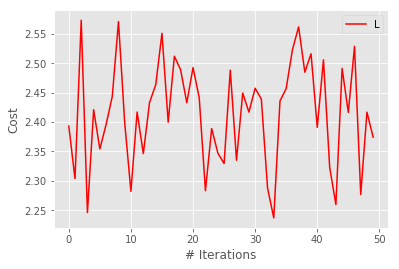

Acc:7.50%: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.64it/s]


Overall Accuracy: 7.50


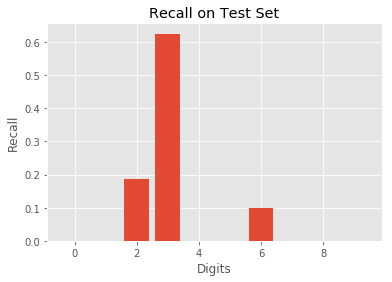

In [8]:
# Training

for epoch in range(num_epochs):
    # Shuffling and creating input_data
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_batch = [X_train[k:k + batch_size] for k in range(0, indices.shape[0], batch_size)]
    
    # Training Batchwise
    cost = []
    t = tqdm(np.arange(X_train.shape[0]/batch_size))  
    for i in t:
        
        i = int(i)
        
        # Cleaning Input Data
        X_batch = X_train[(i*batch_size):((i+1)*batch_size)].reshape((batch_size,X_train.shape[1],X_train.shape[1]))
        Y_batch = Y_train[(i*batch_size):((i+1)*batch_size)].reshape((batch_size,Y_train.shape[1],1))
        
        # Getting Optimized Parameters and Cost
        params,cost = Adam_Gradient_Descent(X_batch,Y_batch,lr,beta1,beta2,params,cost)
        t.set_description("Cost: %.2f" % (cost[-1]))
        
        
        
# Plot cost 
plt.plot(cost, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()


# Testing 


corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]

# Testing Each Instance
t = tqdm(range(X_test.shape[0]))
for i in t:
    
    # Test Data Cleaning
    X_test_input = X_test[i].reshape((1,X_train.shape[1],X_train.shape[1]))
    Y_actual = np.argmax(Y_test[i])
    
    # Predicting the Output
    layers = Forward_Propagation(X_test_input,params)
    Y_pred = np.argmax(layers['probs'])
    
    
    # Calculating Accuracy
    digit_count[Y_actual]+=1
    if Y_pred == Y_actual:
        corr+=1
        digit_correct[Y_pred]+=1

    t.set_description("Acc:%0.2f%%" % (float(corr/(i+1))*100))


# Plot the Obtained Metrics
print("Overall Accuracy: %.2f" % (float(corr/X_test.shape[0]*100)))
x = np.arange(10)
digit_recall = [x/y for x,y in zip(digit_correct, digit_count)]
plt.xlabel('Digits')
plt.ylabel('Recall')
plt.title("Recall on Test Set")
plt.bar(x,digit_recall)
plt.show()

# Implementation in Keras

In [9]:
def Keras_CNN_model(X_train,X_test,Y_train,Y_test):
    
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(8, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(8, kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.summary()

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #train the model
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3)
    
    return history

In [10]:
# Reshape the images.
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

history = Keras_CNN_model(X_train,X_test,Y_train,Y_test)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 8)         1608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               102528    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 105,634
Trainable params: 105,634
Non-trainable params: 

### Reference:
https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca <br>
https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1 <br>
https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5